In [25]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import BPoly
import math
import scipy.signal as signal
import scipy.stats as stats
from scipy import signal
import scipy.fftpack
from scipy.fft import fft, fftfreq
import warnings
warnings.filterwarnings("ignore")


# $$MONOETAPA$$

# MODELO: 2N5486 - NJFET

***
**VALORES DE HOJA DE DATOS**
- IDSS: [8,20]ma
- VP: [-2,-6]V
- rgs: 1M
- ro: inf


In [26]:
VDD=18
RS=470
RG1=820e3
RG2=100e3
IDSSMAX=20e-3
IDSSMED=14e-3
IDSSMIN=8e-3
IDSS=IDSSMED
VPMAX=-6
VPMED=-4
VPMIN=-2
VP=VPMED
RD=1e3
RL=10e3


# Calculo punto de polarizacion para el caso de transferencia minima

In [27]:
def calculoIDQ(idss,vp,vgg,rs):
    a=(rs/vp)**2
    b=( ((2*rs/vp)*(1-(vgg/vp)))-(1/idss) )
    c=(1-(vgg/vp))**2
    return (-b-np.sqrt(b**2 -4*a*c))/(2*a)

In [28]:
parametrosJFET = pd.DataFrame(
                   columns=['IDSS',
                            'VP',
                            'VDD',
                            'RG1', 
                            'RG2',
                            'RS',
                            'RD',
                            'RL',
                            'VGG',
                            'RG',
                            'IDQ',
                            'VGSQ',
                            'VDSQ',
                            'gm',
                            'AV',
                            'rig',
                            'ri'])
parametrosJFET['IDSS']=[IDSSMAX,IDSSMED,IDSSMIN]
parametrosJFET['VP']=[VPMAX,VPMED,VPMIN]
parametrosJFET['VDD']=[VDD,VDD,VDD]
parametrosJFET['RG1']=[RG1,RG1,RG1]
parametrosJFET['RG2']=[RG2,RG2,RG2]
parametrosJFET['RS']=[RS,RS,RS]
parametrosJFET['RD']=[RD,RD,RD]
parametrosJFET['RL']=[RL,RL,RL]
parametrosJFET['VGG']=parametrosJFET['VDD']*parametrosJFET['RG2']/(parametrosJFET['RG1']+parametrosJFET['RG2'])
parametrosJFET['RG']=parametrosJFET['RG1']*parametrosJFET['RG2']/(parametrosJFET['RG1']+parametrosJFET['RG2'])
parametrosJFET['IDQ']= calculoIDQ(parametrosJFET['IDSS'],parametrosJFET['VP'],parametrosJFET['VGG'],parametrosJFET['RS'])
parametrosJFET['VGSQ']=parametrosJFET['VP']*(1-np.sqrt(parametrosJFET['IDQ']/parametrosJFET['IDSS']))
parametrosJFET['VDSQ']=parametrosJFET['VDD']-parametrosJFET['IDQ']*(parametrosJFET['RD']+parametrosJFET['RS'])
parametrosJFET['gm']=(-2/parametrosJFET['VP'])*np.sqrt(parametrosJFET['IDQ']*parametrosJFET['IDSS'])
parametrosJFET['AV']=-parametrosJFET['gm']*(parametrosJFET['RD']*parametrosJFET['RL'])/(parametrosJFET['RD']+parametrosJFET['RL'])
parametrosJFET['rig']=[1e6,1e6,1e6]
parametrosJFET['ri']=(parametrosJFET['rig']*parametrosJFET['RG'])/(parametrosJFET['RG']+parametrosJFET['rig'])

parametrosJFET

,IDSS,VP,VDD,RG1,RG2,RS,RD,RL,VGG,RG,IDQ,VGSQ,VDSQ,gm,AV,rig,ri
0,0.020,-6,18,820000.0,100000.0,470,1000.0,10000.0,1.956522,89130.434783,0.008571,-2.072069,5.399941,0.004364,-3.967607,1000000.0,81836.327345
1,0.014,-4,18,820000.0,100000.0,470,1000.0,10000.0,1.956522,89130.434783,0.006760,-1.220542,8.063225,0.004864,-4.421864,1000000.0,81836.327345
2,0.008,-2,18,820000.0,100000.0,470,1000.0,10000.0,1.956522,89130.434783,0.005040,-0.412481,10.590565,0.006350,-5.772796,1000000.0,81836.327345


**Curva de entrada**


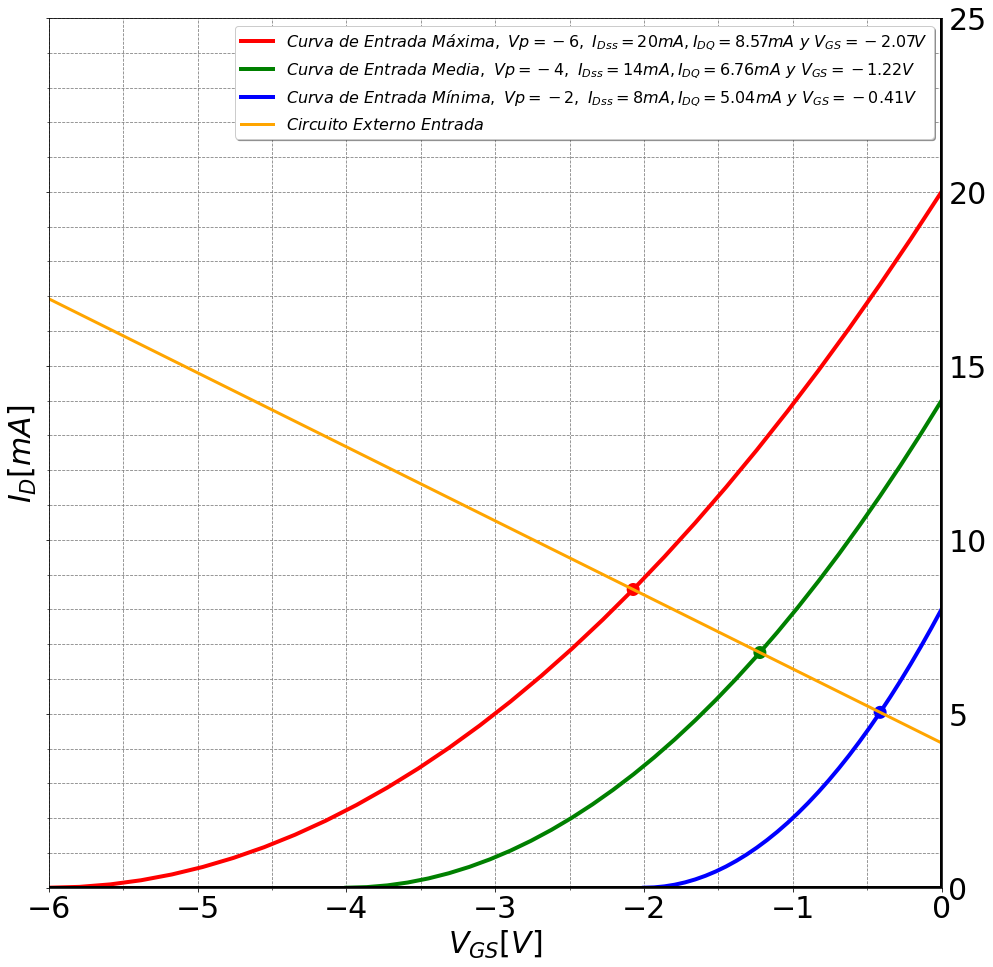

In [29]:

fig = plt.figure(figsize=[16, 16])
ax = fig.gca()
#Aca establezco la subdivicion del grafico
ax.set_xticks(np.linspace(-6, 0, 13), minor=True)
ax.set_yticks(np.linspace(-5,25, 31), minor=True)

ax.tick_params(axis='both', labelsize=30)

#Parametros en los cuatro lados
plt.tick_params(axis='both', labelsize=30, labelleft=False, labelright=True, labeltop=False, labelbottom=True)


#1000*EJERCICIO_A_1_A['time'] es para poner la escala en mili segundos

#SEÑAL DE ENTRADA Vi
vgsMax=np.linspace(-6, 0, 30)
vgsMed=np.linspace(-4, 0, 30)
vgsMin=np.linspace(-2, 0, 30)
vgsRecta=np.linspace(-6, 0, 20)


plt.plot(vgsMax, 20*(1-vgsMax/(-6))**2,linewidth=4.0,c='r',label='$Curva\ de\ Entrada\ Máxima,\ Vp=-6 ,\ I_{Dss}=20mA,I_{DQ}=8.57mA\ y\ V_{GS}=-2.07V$')
plt.plot(vgsMed, 14*(1-vgsMed/(-4))**2,linewidth=4.0,c='g',label='$Curva\ de\ Entrada\ Media,\ Vp=-4 ,\ I_{Dss}=14mA,I_{DQ}=6.76mA\ y\ V_{GS}=-1.22V$')
plt.plot(vgsMin, 8*(1-vgsMin/(-2))**2,linewidth=4.0,c='b',label='$Curva\ de\ Entrada\ Mínima,\ Vp=-2 ,\ I_{Dss}=8mA,I_{DQ}=5.04mA\ y\ V_{GS}=-0.41V$')

plt.scatter(parametrosJFET['VGSQ'],parametrosJFET['IDQ']*1000,c=['r','g','b'],linewidth=7.0)
plt.plot(vgsRecta, ((parametrosJFET['VGG'][0]-vgsRecta)/RS)*1000,linewidth=3.0,c='orange',label='$Circuito\ Externo\ Entrada$')




#EJE HORIZONTAL
ax.axhline(0,linestyle='-',linewidth=4,c='black')
ax.axvline(0,linestyle='-',linewidth=5,c='black')

#Limites del grafico
plt.xlim(-6, 0)
plt.ylim(0, 25)

#Nombre de los ejes
plt.xlabel('$V_{GS}[V]$', fontsize=30)
plt.ylabel('$I_D[mA]$', fontsize=30)

#Parametros del recuadro con nombre de las curvas y tamaño de la fuente
plt.legend(fontsize=16, shadow=True)

plt.grid(which='both',color='grey', linestyle='--')
plt.savefig('Imagenes\Monoetapa\JFETN\CurvaEntrada.png',bbox_inches='tight')


**Curva de Salida**


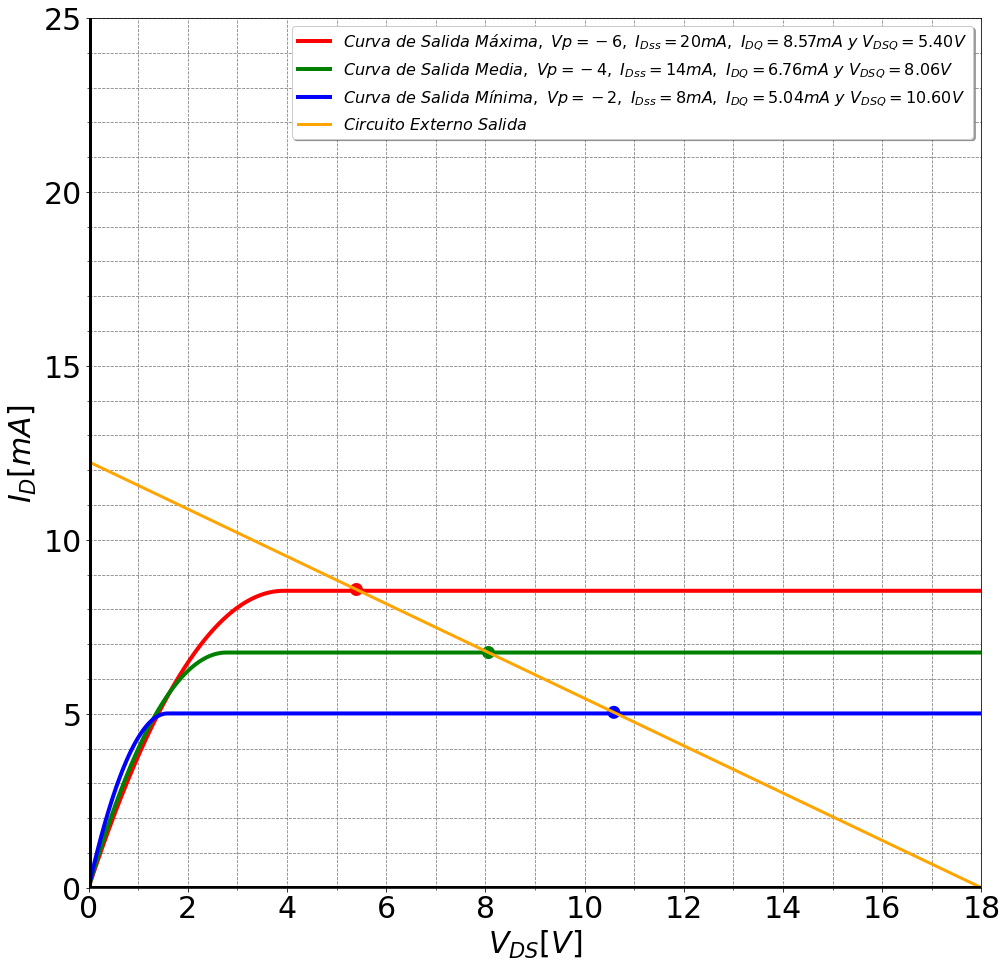

In [30]:
SALIDA_MIN = pd.read_csv("Simulaciones\Monoetapa\JFETN\LTSPICE\JFETN-Salida-MIN.txt", sep='\t')
SALIDA_MED = pd.read_csv("Simulaciones\Monoetapa\JFETN\LTSPICE\JFETN-Salida-MED.txt", sep='\t')
SALIDA_MAX = pd.read_csv("Simulaciones\Monoetapa\JFETN\LTSPICE\JFETN-Salida-MAX.txt", sep='\t')
fig = plt.figure(figsize=[16, 16])
ax = fig.gca()
#Aca establezco la subdivicion del grafico
ax.set_xticks(np.linspace(0, 18, 19), minor=True)
ax.set_yticks(np.linspace(-5,25, 31), minor=True)

ax.tick_params(axis='both', labelsize=30)

#Parametros en los cuatro lados

plt.tick_params(axis='both', labelsize=30, labelleft=True, labelright=False, labeltop=False, labelbottom=True)




#SALIDA


plt.plot(SALIDA_MAX['VDS'], SALIDA_MAX['ID']*1000,linewidth=4.0,c='r',label='$Curva\ de\ Salida\ Máxima,\ Vp=-6,\ I_{Dss}=20mA,\ I_{DQ}=8.57mA\ y\ V_{DSQ}=5.40V$')
plt.plot(SALIDA_MED['VDS'], SALIDA_MED['ID']*1000,linewidth=4.0,c='g',label='$Curva\ de\ Salida\ Media,\ Vp=-4,\ I_{Dss}=14mA,\ I_{DQ}=6.76mA\ y\ V_{DSQ}=8.06V$')
plt.plot(SALIDA_MIN['VDS'], SALIDA_MIN['ID']*1000,linewidth=4.0,c='b',label='$Curva\ de\ Salida\ Mínima,\ Vp=-2,\ I_{Dss}=8mA,\ I_{DQ}=5.04mA\ y\ V_{DSQ}=10.60V$')
plt.scatter(parametrosJFET['VDSQ'],parametrosJFET['IDQ']*1000,c=['r','g','b'],linewidth=7.0)

vdsRecta=np.linspace(0,18, 20)

plt.plot(vdsRecta, (-vdsRecta/(RS+RD) + VDD/(RD+RS))*1000,linewidth=3.0,c='orange',label='$Circuito\ Externo\ Salida$')


#EJE HORIZONTAL
ax.axhline(0,linestyle='-',linewidth=4,c='black')
ax.axvline(0,linestyle='-',linewidth=6,c='black')

#Limites del grafico
plt.xlim(0, 18)
plt.ylim(-0, 25)

#Nombre de los ejes
plt.xlabel('$V_{DS}[V]$', fontsize=30)
plt.ylabel('$I_D[mA]$', fontsize=30)

#Parametros del recuadro con nombre de las curvas y tamaño de la fuente
plt.legend(fontsize=16, shadow=True,loc=1)

plt.grid(which='both',color='grey', linestyle='--')
plt.savefig('Imagenes\Monoetapa\JFETN\CurvaSalida.png',bbox_inches='tight')


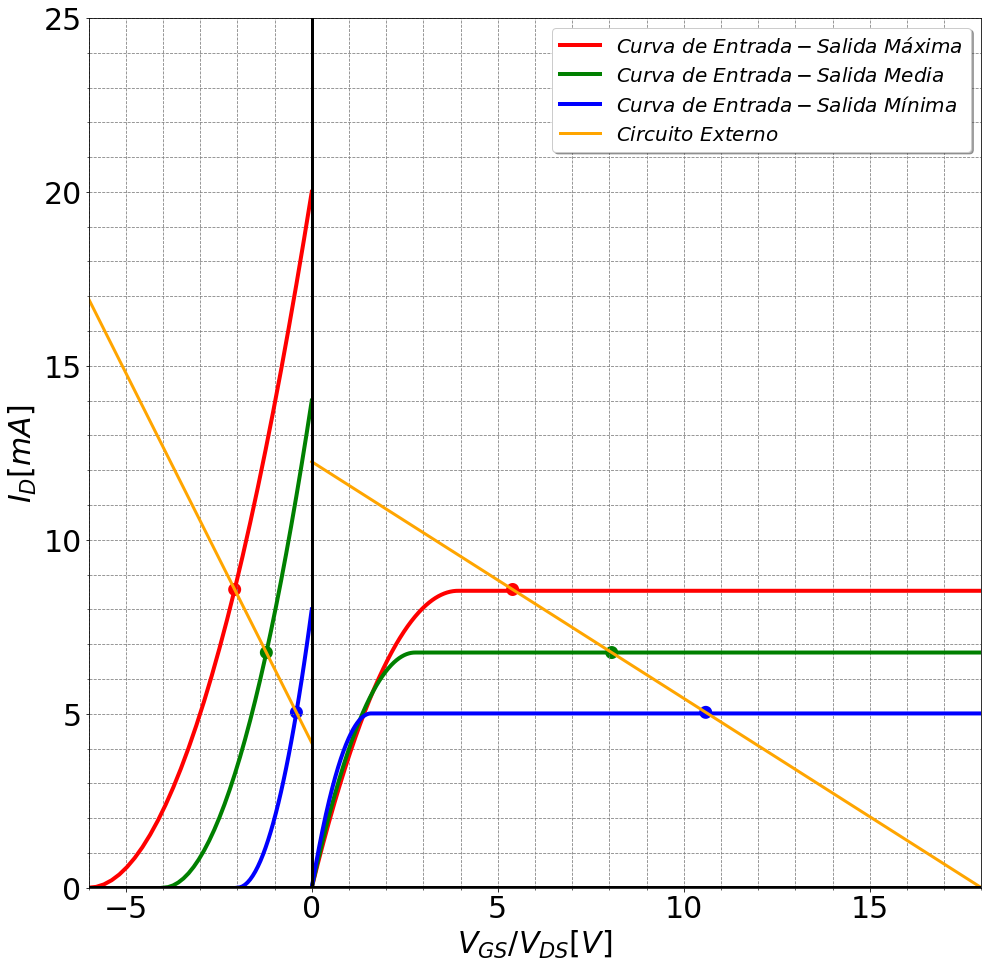

In [31]:
fig = plt.figure(figsize=[16, 16])
ax = fig.gca()
#Aca establezco la subdivicion del grafico
ax.set_xticks(np.linspace(-10, 20, 31), minor=True)
ax.set_yticks(np.linspace(-5,25, 31), minor=True)

ax.tick_params(axis='both', labelsize=30)

#Parametros en los cuatro lados

plt.tick_params(axis='both', labelsize=30, labelleft=True, labelright=False, labeltop=False, labelbottom=True)


#ENTRADA

vgsMax=np.linspace(-6, 0, 30)
vgsMed=np.linspace(-4, 0, 30)
vgsMin=np.linspace(-2, 0, 30)

plt.plot(vgsMax, 20*(1-vgsMax/(-6))**2,linewidth=4.0,c='r',label='$Curva\ de\ Entrada-Salida\ Máxima$')
plt.plot(vgsMed, 14*(1-vgsMed/(-4))**2,linewidth=4.0,c='g',label='$Curva\ de\ Entrada-Salida\ Media$')
plt.plot(vgsMin, 8*(1-vgsMin/(-2))**2,linewidth=4.0,c='b',label='$Curva\ de\ Entrada-Salida\ Mínima$')

plt.scatter(parametrosJFET['VGSQ'],parametrosJFET['IDQ']*1000,c=['r','g','b'],linewidth=7.0)


#SALIDA
plt.plot(SALIDA_MAX['VDS'], SALIDA_MAX['ID']*1000,linewidth=4.0,c='r')
plt.plot(SALIDA_MED['VDS'], SALIDA_MED['ID']*1000,linewidth=4.0,c='g')
plt.plot(SALIDA_MIN['VDS'], SALIDA_MIN['ID']*1000,linewidth=4.0,c='b')
plt.scatter(parametrosJFET['VDSQ'],parametrosJFET['IDQ']*1000,c=['r','g','b'],linewidth=7.0)

vdsRecta=np.linspace(0,18, 20)
plt.plot(vdsRecta, (-vdsRecta/(RS+RD) + VDD/(RD+RS))*1000,linewidth=3.0,c='orange')

vgsRecta=np.linspace(-6, 0, 20)
plt.plot(vgsRecta, ((parametrosJFET['VGG'][0]-vgsRecta)/RS)*1000,linewidth=3.0,c='orange',label='$Circuito\ Externo$')


#EJE HORIZONTAL
ax.axhline(0,linestyle='-',linewidth=4,c='black')
ax.axvline(0,linestyle='-',linewidth=3,c='black')

#Limites del grafico
plt.xlim(-6, 18)
plt.ylim(-0, 25)

#Nombre de los ejes
plt.xlabel('$V_{GS}/V_{DS}[V]$', fontsize=30)
plt.ylabel('$I_D[mA]$', fontsize=30)

#Parametros del recuadro con nombre de las curvas y tamaño de la fuente
plt.legend(fontsize=20, shadow=True,loc=1)

plt.grid(which='both',color='grey', linestyle='--')
plt.savefig('Imagenes\Monoetapa\JFETN\CurvaEntradaSalida.png',bbox_inches='tight')


**BODE**

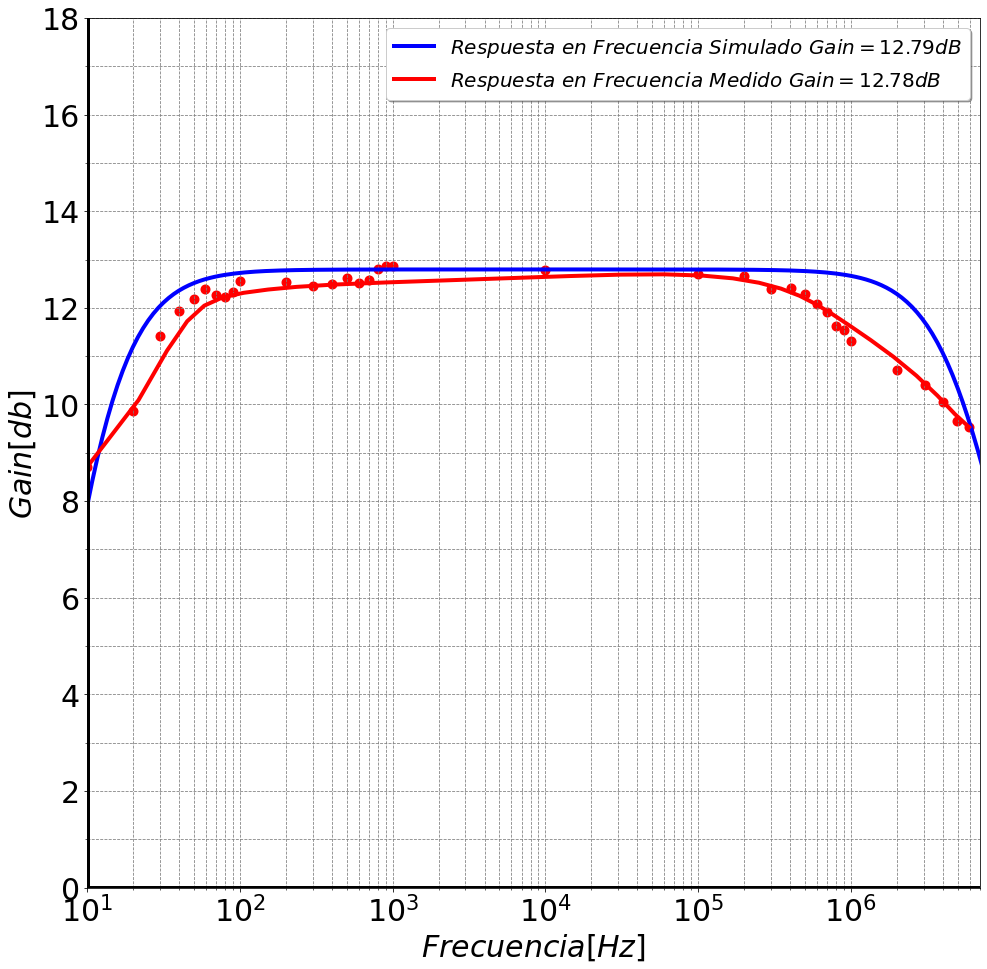

In [32]:
BODE_MONOETAPA_MED=pd.read_csv(r"Mediciones\Monoetapa\NJFET\JFETN.txt", sep='\t')
BODE_MONOETAPA_SIM = pd.read_csv("Simulaciones\Monoetapa\JFETN\LTSPICE\BODE.txt", sep='\t')
#################################################################################################
#Creo un pandas auxiliar para hacer Bezier
BODE_MONO_MED_BEZ = pd.DataFrame(
                   columns=['Frecuencia',
                            'Ganancia'])
BODE_MONO_MED_BEZ['Frecuencia']=BODE_MONOETAPA_MED['Frecuencia']
BODE_MONO_MED_BEZ['Ganancia']=20*np.log10(BODE_MONOETAPA_MED['Vo']/BODE_MONOETAPA_MED['Vi'])
arreglo_bez=np.array(BODE_MONO_MED_BEZ.values.tolist())

curva=BPoly(arreglo_bez[:,None,:],[0,1])
X=np.linspace(0,1,30)

p=curva(X)



#################################################################################################
fig = plt.figure(figsize=[16, 16])
ax = fig.add_subplot(1,1,1)

ax.tick_params(axis='both', labelsize=30, labelleft=True, labelright=False, labeltop=False, labelbottom=True)

ax.set_yticks(np.linspace(0, 25, 26), minor=True)

plt.plot()

ax.plot(BODE_MONOETAPA_SIM['Frecuencia'], BODE_MONOETAPA_SIM['Ganancia'],linewidth=4.0,c='b',label='$Respuesta\ en\ Frecuencia\ Simulado\ Gain=12.79dB$')

ax.plot(*p.T,linewidth=4.0,c='r',label='$Respuesta\ en\ Frecuencia\ Medido\ Gain=12.78dB$')
ax.scatter(BODE_MONO_MED_BEZ['Frecuencia'],BODE_MONO_MED_BEZ['Ganancia'],linewidth=4.0,c='r')
ax.axhline(0,linestyle='-',linewidth=4,c='black')
ax.axvline(10,linestyle='-',linewidth=5,c='black')

#ax.plot(frecuencia, ganacia)
ax.set_xlabel('$Frecuencia[Hz]$', fontsize=30)
ax.set_ylabel('$Gain[db]$', fontsize=30)

# ax.plot(frecuencia, ganacia)
ax.set_xticks(np.linspace(-0.75, -0.15, 25), minor=True)

plt.xlim(10,7e6)
plt.ylim(0, 18)
ax.set_xscale('log')
plt.grid(which='both',color='grey', linestyle='--')
plt.legend(fontsize=20, shadow=True,loc=1)
plt.savefig('Imagenes\Monoetapa\JFETN\BODE.png',bbox_inches='tight')


# $$MULTIETAPA$$

# MODELO: 2N5486 - NJFET

***
**VALORES DE HOJA DE DATOS**
- IDSS: [8,20]ma
- VP: [-2,-6]V
- rgs: 1M
- ro: inf


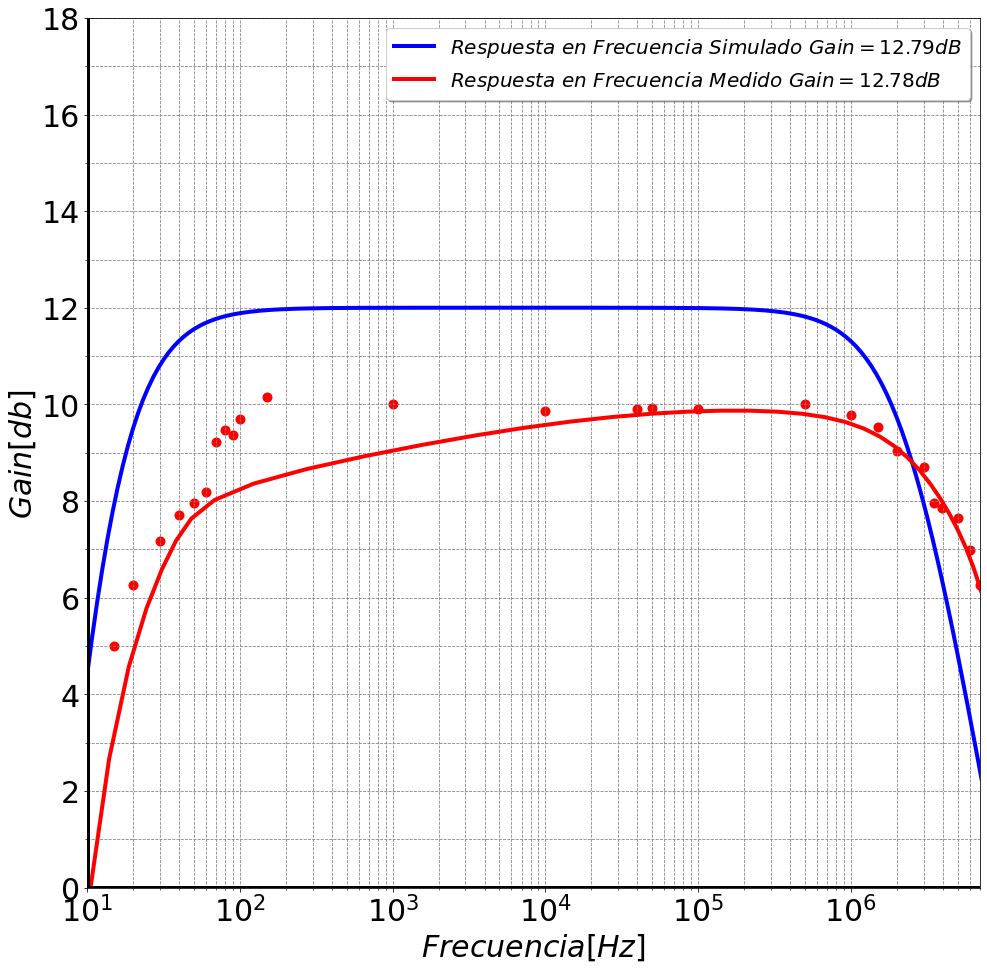

In [33]:
BODE_MULTIETAPA_MED=pd.read_csv(r"Mediciones\Multietapa\NJFET\JFETN.txt", sep='\t')
BODE_MULTIETAPA_SIM = pd.read_csv("Simulaciones\Multietapa\JFETN\LTSPICE\BODE.txt", sep='\t')
#################################################################################################
#Creo un pandas auxiliar para hacer Bezier
BODE_MULTI_MED_BEZ = pd.DataFrame(
                   columns=['Frecuencia',
                            'Ganancia'])
BODE_MULTI_MED_BEZ['Frecuencia']=BODE_MULTIETAPA_MED['Frecuencia']
BODE_MULTI_MED_BEZ['Ganancia']=20*np.log10(BODE_MULTIETAPA_MED['Vo']/BODE_MULTIETAPA_MED['Vi'])
arreglo_bez=np.array(BODE_MULTI_MED_BEZ.values.tolist())

curva=BPoly(arreglo_bez[:,None,:],[0,1])
X=np.linspace(0,1,40)

p=curva(X)



#################################################################################################
fig = plt.figure(figsize=[16, 16])
ax = fig.add_subplot(1,1,1)

ax.tick_params(axis='both', labelsize=30, labelleft=True, labelright=False, labeltop=False, labelbottom=True)

ax.set_yticks(np.linspace(0, 25, 26), minor=True)

plt.plot()

ax.plot(BODE_MULTIETAPA_SIM['Frecuencia'], BODE_MULTIETAPA_SIM['Ganancia'],linewidth=4.0,c='b',label='$Respuesta\ en\ Frecuencia\ Simulado\ Gain=12.79dB$')

ax.plot(*p.T,linewidth=4.0,c='r',label='$Respuesta\ en\ Frecuencia\ Medido\ Gain=12.78dB$')
ax.scatter(BODE_MULTI_MED_BEZ['Frecuencia'],BODE_MULTI_MED_BEZ['Ganancia'],linewidth=4.0,c='r')
ax.axhline(0,linestyle='-',linewidth=4,c='black')
ax.axvline(10,linestyle='-',linewidth=5,c='black')

#ax.plot(frecuencia, ganacia)
ax.set_xlabel('$Frecuencia[Hz]$', fontsize=30)
ax.set_ylabel('$Gain[db]$', fontsize=30)

# ax.plot(frecuencia, ganacia)
ax.set_xticks(np.linspace(-0.75, -0.15, 25), minor=True)

plt.xlim(10,7e6)
plt.ylim(0, 18)
ax.set_xscale('log')
plt.grid(which='both',color='grey', linestyle='--')
plt.legend(fontsize=20, shadow=True,loc=1)
plt.savefig('Imagenes\Multietapa\JFETN\BODE.png',bbox_inches='tight')

# $$OSCILADOR$$

# MODELO: BC548B - NJFET

***
**VALORES DE HOJA DE DATOS**
- beta: [200,450], Typ=290
- Vbe: [0.55,0.7]V
- Vcesat: 0.2V

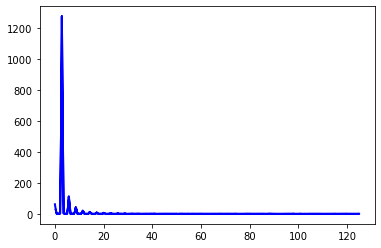

In [63]:
OSCILADOR_MED=pd.read_csv(r"Mediciones\Oscilador\GAS0001.CSV", sep='\t')
arr= list(OSCILADOR_MED['Vo'])
N=len(arr)
w = signal.hamming(N)
yf = fft(arr*w)
ywf = fft(arr)
xf = fftfreq(len(arr),0.004/1000)

plt.plot(np.abs(xf)/1000, np.abs(yf),linewidth=2.0,c='b',label='$FFT\ Hamming$')
OSCILADOR_MED=pd.read_csv(r"Mediciones\Oscilador\GAS0001.CSV", sep='\t')


In [65]:
OSCILADOR_MED


,Time,Vo
0,1,-1.04
1,2,-0.48
2,3,0.08
3,4,0.72
4,5,1.36
...,...,...
695,696,-2.00
696,697,-1.36
697,698,-0.88
698,699,-0.24


(100.0, 10000.0)

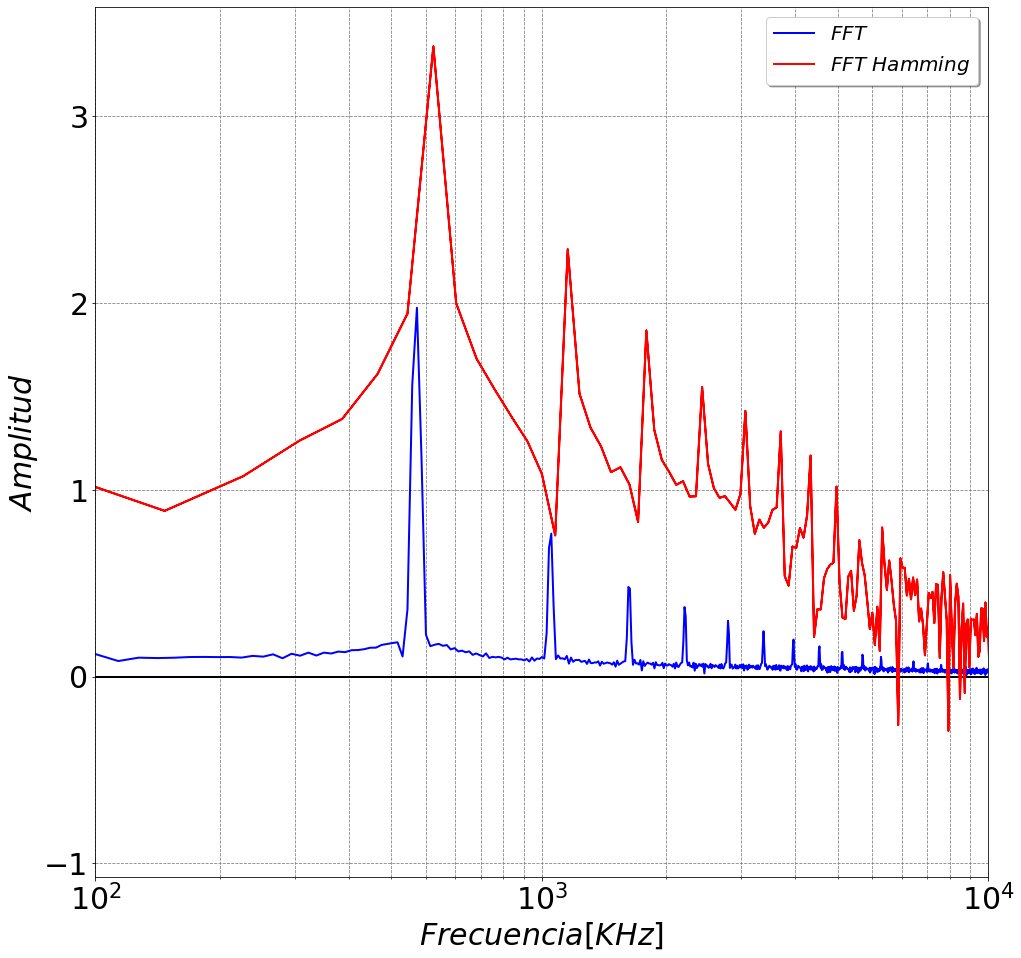

In [94]:
OSCILADOR_FFT_SIM=pd.read_csv(r"Simulaciones\Oscilador\FFTSIM.txt", sep='\t')

fig = plt.figure(figsize=[16, 16])

ax = fig.gca()
#Aca establezco la subdivicion del grafico

#Aca establezco la subdivicion del grafico
ax.set_xticks(np.linspace(0, 100, 11), minor=True)
ax.tick_params(axis='both', labelsize=30)

ax.axhline(0,linestyle='-',linewidth=2,c='black')




plt.plot(OSCILADOR_FFT_SIM['Frecuencia'],np.exp(OSCILADOR_FFT_SIM['Vo']/20),linewidth=2.0,c='b',label='$FFT$')
arr= list(OSCILADOR_MED['Vo'])
N=len(arr)
w = signal.square(N)
yf = fft(arr*w)
ywf = fft(arr)
xf = fftfreq(len(arr),0.00002/1000)

plt.plot(np.abs(xf)/1000, np.log10(np.abs(yf)),linewidth=2.0,c='r',label='$FFT\ Hamming$')
plt.grid(which='both',color='grey', linestyle='--')
plt.xlabel('$Frecuencia[KHz]$', fontsize=30)
plt.ylabel('$Amplitud$', fontsize=30)
ax.set_xscale('symlog')


a=np.append(np.linspace(0, 1, 11),np.linspace(1, 10, 11))
a=np.append(a,np.linspace(10, 100, 11))
a=np.append(a,np.linspace(100, 1000, 11))
a=np.append(a,np.linspace(1000, 10000, 11))


ax.set_xticks(a, minor=True)
plt.legend(fontsize=20, shadow=True)
plt.xlim(100,10000)



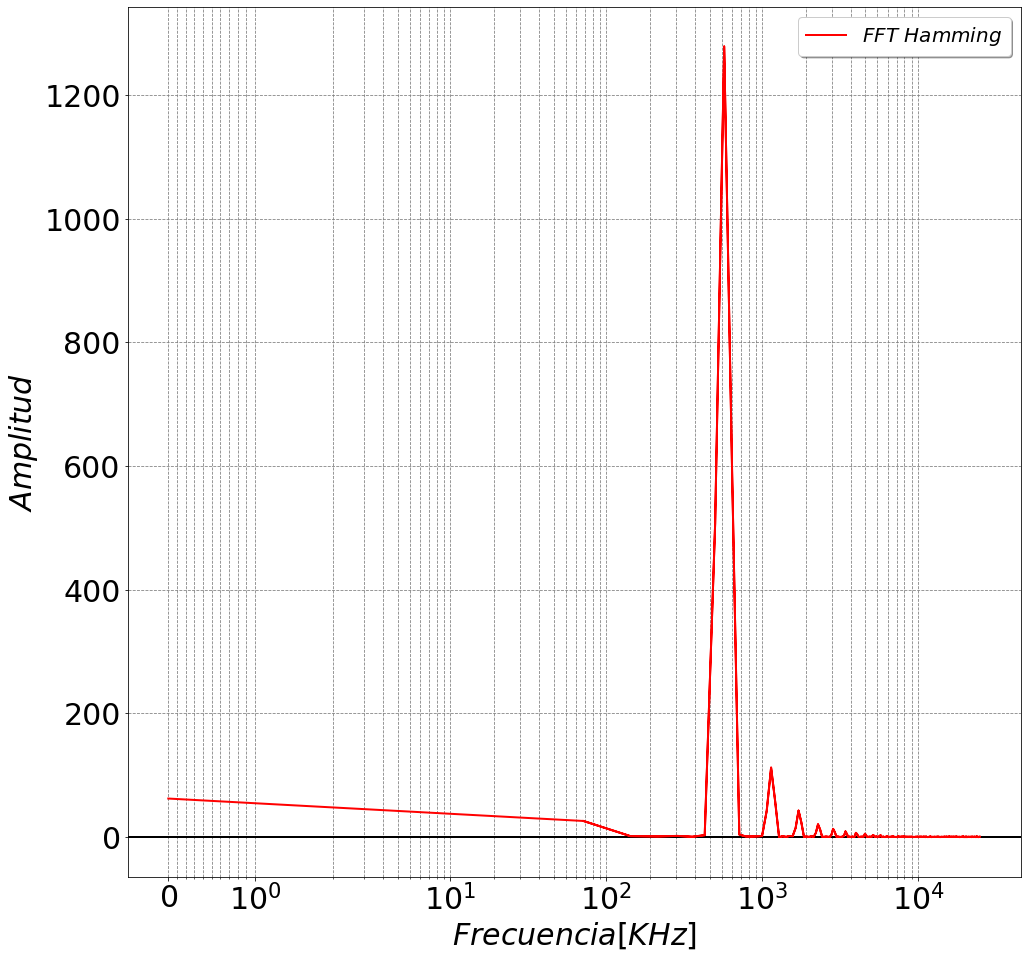

In [71]:
OSCILADOR_FFT_SIM=pd.read_csv(r"Simulaciones\Oscilador\FFTSIM.txt", sep='\t')

fig = plt.figure(figsize=[16, 16])

ax = fig.gca()
#Aca establezco la subdivicion del grafico

#Aca establezco la subdivicion del grafico
ax.set_xticks(np.linspace(0, 100, 11), minor=True)
ax.tick_params(axis='both', labelsize=30)

ax.axhline(0,linestyle='-',linewidth=2,c='black')




arr= list(OSCILADOR_MED['Vo'])
N=len(arr)
w = signal.hamming(N)
yf = fft(arr*w)
ywf = fft(arr)
xf = fftfreq(len(arr),0.00002/1000)

plt.plot(np.abs(xf)/1000, np.abs(yf),linewidth=2.0,c='r',label='$FFT\ Hamming$')
plt.grid(which='both',color='grey', linestyle='--')
plt.xlabel('$Frecuencia[KHz]$', fontsize=30)
plt.ylabel('$Amplitud$', fontsize=30)
ax.set_xscale('symlog')


a=np.append(np.linspace(0, 1, 11),np.linspace(1, 10, 11))
a=np.append(a,np.linspace(10, 100, 11))
a=np.append(a,np.linspace(100, 1000, 11))
a=np.append(a,np.linspace(1000, 10000, 11))


ax.set_xticks(a, minor=True)
plt.legend(fontsize=20, shadow=True)


